##  Bike Sharing Demand Prediction using Deep Learning

This notebook deploys several models using Tensorflow library including:
- Convolutional Neural Networks (CNNs)
- Long short-term memory (LSTM)
- Linear Regression (LR) as a benchmark method

**Metadata of the dataset:**

**"timestamp"** - timestamp field for grouping the data
**"cnt"** - the count of a new bike shares
**"t1"** - real temperature in C
**"t2"** - temperature in C "feels like"
**"hum"** - humidity in percentage
**"windspeed"** - wind speed in km/h
**"weathercode"** - category of the weather
**"isholiday"** - boolean field - 1 holiday / 0 non holiday
**"isweekend"** - boolean field - 1 if the day is weekend
**"season"** - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

**"weathe_code"** category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [1]:
# import libraries

import os
import datetime
import numpy as np 
import pandas as pd 
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import IPython
import IPython.display

mpl.style.use('bmh')

In [2]:
# loading the dataset

data = pd.read_csv("../input/london-bike-sharing-dataset/london_merged.csv")
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
# general data exploration

data.describe().transpose() # no missing values found

,count,mean,std,min,25%,50%,75%,max
cnt,17414.0,1143.101642,1085.108068,0.0,257.0,844.0,1671.75,7860.0
t1,17414.0,12.468091,5.571818,-1.5,8.0,12.5,16.00,34.0
t2,17414.0,11.520836,6.615145,-6.0,6.0,12.5,16.00,34.0
hum,17414.0,72.324954,14.313186,20.5,63.0,74.5,83.00,100.0
wind_speed,17414.0,15.913063,7.894570,0.0,10.0,15.0,20.50,56.5
weather_code,17414.0,2.722752,2.341163,1.0,1.0,2.0,3.00,26.0
is_holiday,17414.0,0.022051,0.146854,0.0,0.0,0.0,0.00,1.0
is_weekend,17414.0,0.285403,0.451619,0.0,0.0,0.0,1.00,1.0
season,17414.0,1.492075,1.118911,0.0,0.0,1.0,2.00,3.0


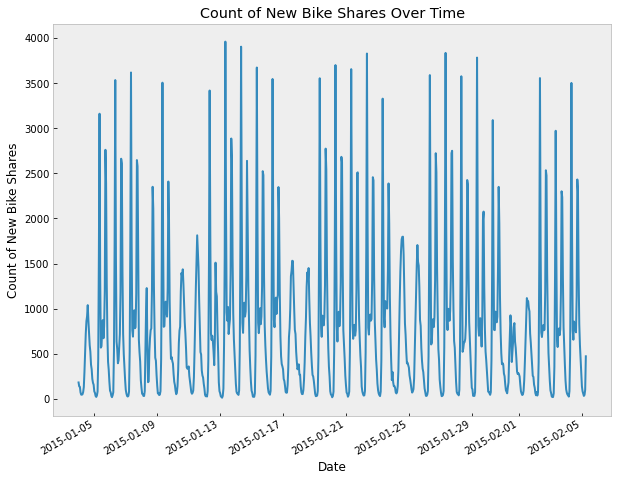

In [4]:
# visualisation - count of new bike shares over one month

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

vis_data = data[['timestamp', 'cnt']]
vis_data.set_index('timestamp', inplace=True) 
vis_data.index = pd.to_datetime(vis_data.index) # converting timestamp to datetime object

vis_data = vis_data['cnt'][:774]

vis_data.plot()
plt.xlabel("Date")
plt.ylabel("Count of New Bike Shares")
plt.title('Count of New Bike Shares Over Time')
plt.show()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff094535c90>,
      dtype=object)

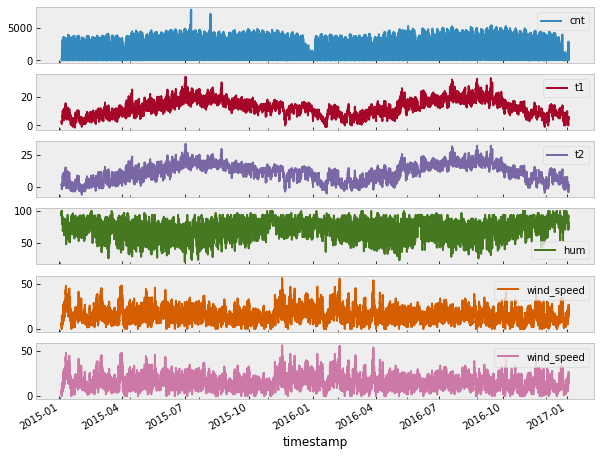

In [5]:
# plotting the features - cnt, t1, t2, hum, wind_speed, weather_code against time

timestamp = data['timestamp']
timestamp = pd.to_datetime(timestamp, format = '%Y-%m-%d %H:%M:%S')
vis_cols = ['cnt','t1', 't2', 'hum', 'wind_speed', 'wind_speed']
vis_features = data[vis_cols]
vis_features.index = timestamp
vis_features.plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0924e16d0>,
      dtype=object)

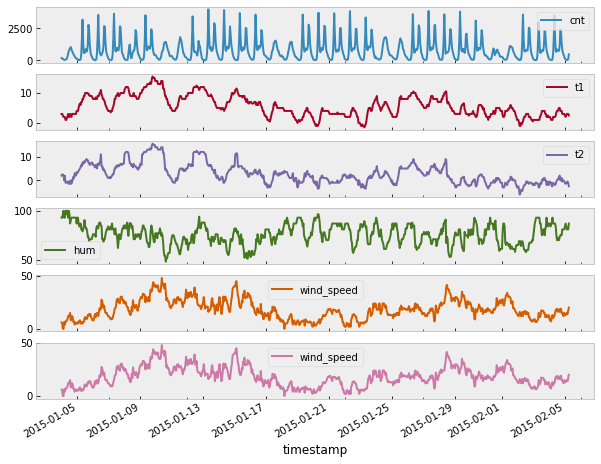

In [9]:
# limiting visualised period to one month 01/2015 - 02/2015
vis_features = data[vis_cols][:774]
vis_features.index = timestamp[:774]
vis_features.plot(subplots=True)

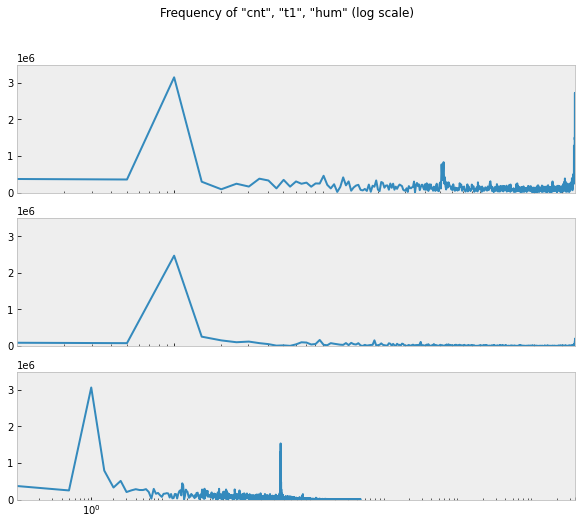

In [10]:
# confirming assumption about important features with 'Real-valued fast Fourier transform'

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Frequency of "cnt", "t1", "hum" (log scale)')


n_samples_h = len(data['cnt'])
hours_per_year = 24*365
years_per_dataset = n_samples_h/(hours_per_year)

fft_cnt = tf.signal.rfft(data['cnt'])
f_per_dataset_cnt = np.arange(0, len(fft_cnt))
f_per_year_cnt = f_per_dataset_cnt/years_per_dataset

fft_t1 = tf.signal.rfft(data['t1'])
f_per_dataset_t1 = np.arange(0, len(fft_t1))
f_per_year_t1 = f_per_dataset_t1/years_per_dataset

fft_hum = tf.signal.rfft(data['hum'])
f_per_dataset_hum = np.arange(0, len(fft_hum))
f_per_year_hum = f_per_dataset_hum/years_per_dataset

axs[0].plot(f_per_year_cnt, np.abs(fft_cnt))
axs[0].set_xscale('log')
axs[0].set_ylim(0, 3500000)
axs[0].set_xlim([0.1, 365])
axs[0].set_xticks([1, 3500000])

axs[1].plot(f_per_year_t1, np.abs(fft_t1 ** 1.35))
axs[1].set_xscale('log')
axs[1].set_xlim([0.1, 365])
axs[1].set_xticks([1, 3500000])

axs[2].plot(f_per_year_hum, np.abs(fft_hum ** 1.35))
axs[2].set_xscale('log')
axs[2].set_xlim([0.1, 365])
axs[2].set_xticks([1, 3500000])

In [11]:
# data preparation 
# converting time to seconds
timestamp_s = timestamp.map(datetime.datetime.timestamp)

# dealling with periodicity by converting 'cnt' to signals using sin / cos approach
day = 86400
year = 365*day
data['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
data.tail()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,day_sin,day_cos,year_sin,year_cos
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0,-0.965926,0.258819,0.251884,0.967757
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0,-0.866025,0.500000,0.252578,0.967576
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0,-0.707107,0.707107,0.253272,0.967395
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0,-0.500000,0.866025,0.253966,0.967213
17413,2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0,-0.258819,0.965926,0.254660,0.967031


In [14]:
# splitting data on train test and validation sets (70%, 20%, 10%)

data_dt = data[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season', 'day_sin', 'day_cos', 'year_sin', 'year_cos']]

n = len(data_dt)
train_df = data_dt[0:int(n*0.7)]
val_df = data_dt[int(n*0.7):int(n*0.9)]
test_df = data_dt[int(n*0.9):]

num_feat = data.shape[1]

In [15]:
# Normalisation: Min-Max Scaling 

train_max = train_df.max()
train_min = train_df.min()

train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

df_std = (data_dt - train_min) / (train_max - train_min)
df_std = df_std.melt(var_name='feature', value_name='normalized')

In [16]:
# creating classes: generate window, split window, plot.
# adapted from https://www.tensorflow.org/tutorials/structured_data/time_series

class generate_window():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


# visualisation of the window
def plot(self, model=None, plot_col='cnt', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(18, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    marker='o', edgecolors='face', label='Labels', c='#4e8f18', s=84)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='*', edgecolors='face', label='Predictions',
                      c='#7b63b0', s=84)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

generate_window.make_dataset = make_dataset
generate_window.plot = plot
generate_window.split_window = split_window


@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

generate_window.train = train
generate_window.val = val
generate_window.test = test
generate_window.example = example


MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


single_step_window = generate_window(
    input_width=1, label_width=1, shift=1,
    label_columns=['cnt'])

wide_window = generate_window(
    input_width=24, label_width=24, shift=1,
    label_columns=['cnt'])

In [17]:
# building models

# linear model

linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)
val_performance = {}
performance = {}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/30
381/381 [==============================] - 2s 4ms/step - loss: 0.0901 - mean_absolute_error: 0.2326 - val_loss: 0.0592 - val_mean_absolute_error: 0.1940
Epoch 2/30
381/381 [==============================] - 1s 3ms/step - loss: 0.0237 - mean_absolute_error: 0.1202 - val_loss: 0.0206 - val_mean_absolute_error: 0.1107
Epoch 3/30
381/381 [==============================] - 1s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0839 - val_loss: 0.0142 - val_mean_absolute_error: 0.0870
Epoch 4/30
381/381 [==============================] - 1s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0700 - val_loss: 0.0115 - val_mean_absolute_error: 0.0752
Epoch 5/30
381/381 [==============================] - 1s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0617 - val_loss: 0.0100 - val_mean_absolute_error: 0.0681
Epoch 6/30
381/381 [==============================] - 1s 4ms/step - loss: 0.0071 - mean_absolute_error: 0.0565 - val_loss: 0.0092 - val_mean_absolute_error: 0.0647
Epoch 7/30
381/3

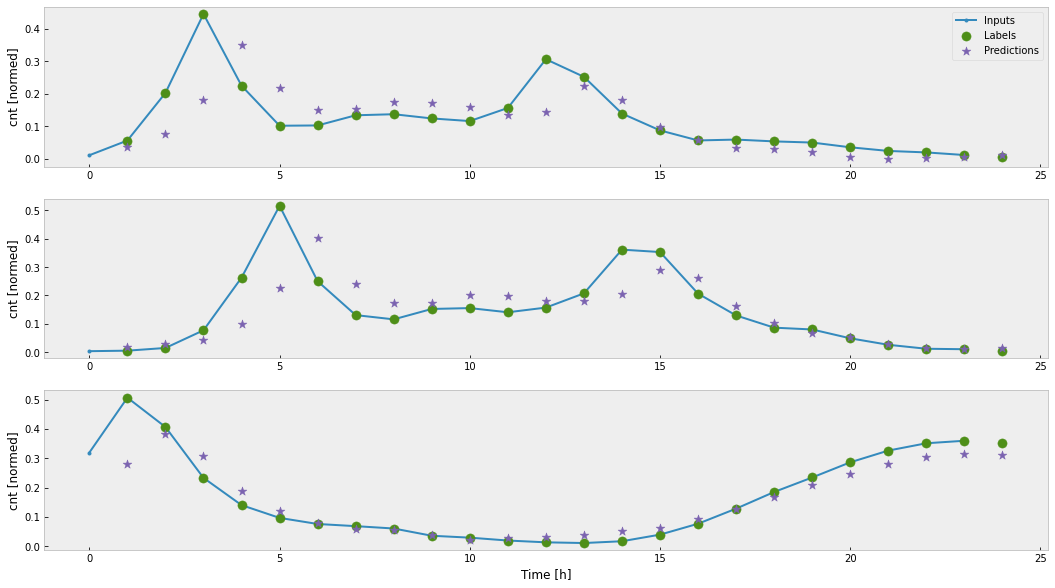

In [18]:
wide_window.plot(linear)

In [19]:
# CNN model

OUT_STEPS = 24

CONV_WIDTH = 7
conv_window = generate_window(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['cnt'])

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_feat,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_feat])
])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = generate_window(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['cnt'])

109/109 [==============================] - 0s 3ms/step - loss: 0.0010 - mean_absolute_error: 0.0217


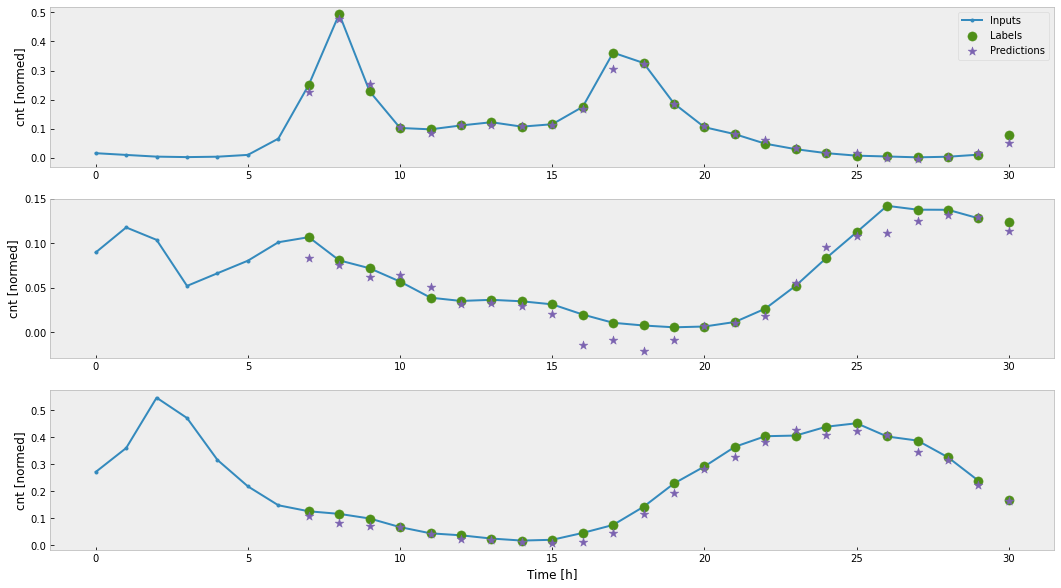

In [20]:
wide_conv_window.plot(conv_model)

In [21]:
# RNN - LSTM model

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

109/109 [==============================] - 1s 5ms/step - loss: 8.1829e-04 - mean_absolute_error: 0.0173


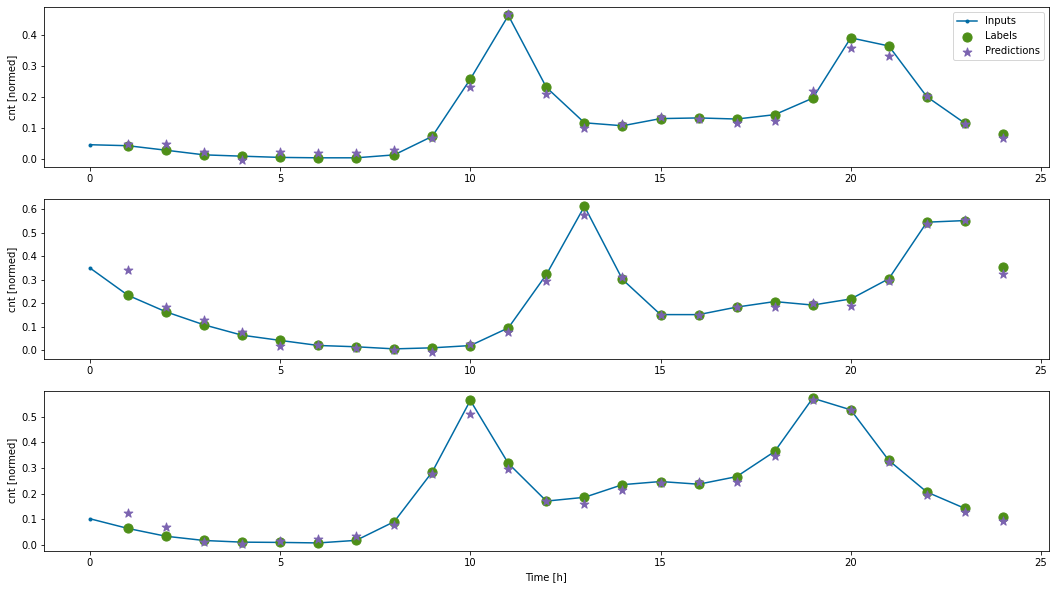

In [21]:
wide_window.plot(lstm_model)

In [35]:
for model, value in performance.items():
    print(f'{model:6s}: {value[1]:0.5f}')

Linear: 0.04229
Conv  : 0.01862
LSTM  : 0.01468


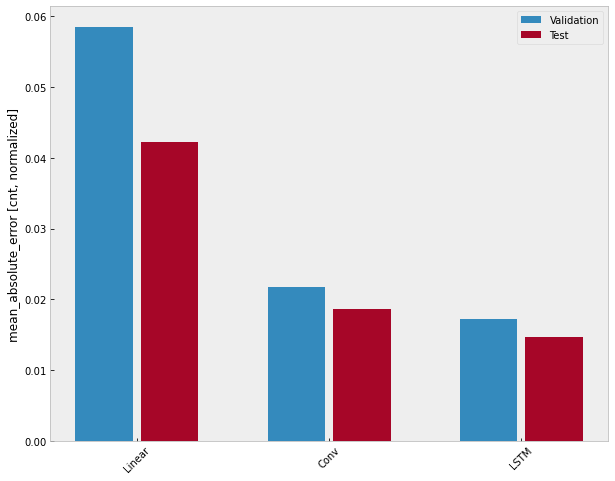

In [22]:
# evaluating the performance

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [cnt, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend()

Among tested models LSTM approach shows better performance on both test and validation sets, providing lowest MAE value on the normalised data - 0.01468, while a linear method resulted in MAE - 0.04229.

**References:**
1. Geron, Aurelien (2019): Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems: O'Reilly Media, Incorporated.

2. Time series forecasting. Tensorflow tutorial:
https://www.tensorflow.org/tutorials/structured_data/time_series

3. The data is acquired from 3 sources: Https://cycling.data.tfl.gov.uk/ 'Contains OS data © Crown copyright and database rights 2016' and Geomni UK Map data © and database rights [2019] 'Powered by TfL Open Data' freemeteo.com - weather data https://www.gov.uk/bank-holidays From 1/1/2015 to 31/12/2016